In [1]:
from copy import deepcopy
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import topogap_protocol as tgp
# from plot_region_of_interest_2 import plot_region_of_interest_2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

SMALL_SIZE = 13
MEDIUM_SIZE = 13
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
xr_c_dataset_left, xr_c_dataset_right = tgp.load_phase2_data('deviceC_P724BB_00BA_1A_phase2_run2.nc')

In [3]:
region = tgp.PhaseTwoRegionData(xr_datasets={'left':xr_c_dataset_left, 'right':xr_c_dataset_right}, region=0)

PhaseTwoRegionData is ready.


In [4]:
region.extract_gap(threshold_factor=0.05,gauss_sigma=(0,0.),shift=False)

In [5]:
zbp_ds = region.extract_zbp_dataset_derivative(
    average_over_cutter = True, 
    derivative_threshold = 2 * 0.5 / 0.05 ** 2 * 1 /4 ,
    probability_threshold= 0.5,
    bias_window = 10e-3, # 0.5e-5 ??
    combine_gaps = "min", #geometric"
)

In [6]:
# %load_ext autoreload
# %autoreload 2

run_name = 'P724BB_00BA_1A_phase2_run2'
device_n = 'deviceC'

c_test = 0
# p_test = -2.722
p_test = -2.7221
tf = 0.05
ms = 2
gs = (0,0)

In [7]:
def plot(c_test=c_test, p_test=p_test):
    print(device_n, run_name, '   c_test =', c_test, '   p_test =', p_test, '   tf =', tf)

    g_ll = region.data['left'].sel({'p':p_test,'lc':c_test},method="nearest").g_ll
    B = np.array(g_ll['f'])
    lb = np.array(g_ll['lb'])
    g_ll = np.array(g_ll)[0,0,:,:]

    g_rr = region.data['right'].sel({'p':p_test,'rc':c_test},method="nearest").g_rr
    # B = np.array(g_rr['f'])
    rb = np.array(g_rr['rb'])
    g_rr = np.array(g_rr)[0,0,:,:]

    n = 400
    cmap1 = mpl.cm.get_cmap('viridis', n+1)
    cmap2 = mpl.cm.get_cmap('PuOr_r', n+1)

    # fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(4*2, 3*2))
    fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(4.2*4, 3*1))

    ax1 = plt.subplot(141)
    pcm = plt.pcolormesh(B, lb, g_ll.T, shading='auto', vmin=0, vmax=1, cmap=cmap1, linewidth=0, rasterized=True)
    pcm.set_edgecolor('face')
    # plt.title(r'$G_\mathrm{LL}$ [$e^2/h$]')
    plt.xlabel('$B$ [T]')
    plt.ylabel('Left bias [mV]')
    cb = plt.colorbar(extend='max')
    # cb.set_ticks([0, 0.5, 1])
    cb.set_label('$G_\mathrm{LL}$ [$e^2/h$]')
    # plt.xticks([0.5, 1, 1.5, 2])

    ax2 = plt.subplot(142)
    pcm = plt.pcolormesh(B, rb, g_rr.T, shading='auto', vmin=0, vmax=1, cmap=cmap1, linewidth=0, rasterized=True)
    pcm.set_edgecolor('face')
    # Right bias [mV]
    # plt.title(r'$G_\mathrm{RR}$ [$e^2/h$]')
    plt.ylabel('Right bias [mV]')
    plt.xlabel('$B$ [T]')
    cb = plt.colorbar(extend='max')
    # cb.set_ticks([0, 0.5, 1])
    cb.set_label(r'$G_\mathrm{RR}$ [$e^2/h$]')
    # plt.xticks([0.5, 1, 1.5, 2])

    ax3 = plt.subplot(143)
    test = tgp.gap_extraction.determine_gap_2D(region.data['left'].sel({'p':p_test,'lc':c_test},method="nearest").g_rl,bias_name="lb",
                                                 filtered_antisym_g=True,gauss_sigma=gs,median_size=ms,threshold_factor=tf,shift=False)
    pcm = plot = test[1].plot(cbar_kwargs={'label':r'$A(G_\mathrm{RL})$ [$e^2/h$]', 'extend':'both'}, vmax=0.07, shading='auto', cmap=cmap2, linewidth=0, rasterized=True)
    pcm.set_edgecolor('face')
    ((test[0] >0) * (test[0])).plot(c='black')
    (- ((test[0] >0) * (test[0]))).plot(c='black')
    # plt.title('$Vp = ' + str(p_test) + ' V')
    # cb = plt.colorbar(extend='both')
    plt.title('')
    plt.ylabel('Left bias [mV]')
    plt.xlabel('$B$ [T]')
    # plt.xticks([0.5, 1, 1.5, 2])

    ax4 = plt.subplot(144)
    test = tgp.gap_extraction.determine_gap_2D(region.data['right'].sel({'p':p_test,'rc':c_test},method="nearest").g_lr,bias_name="rb",
                                                 filtered_antisym_g=True,gauss_sigma=gs,median_size=ms,threshold_factor=tf,shift=False)
    pcm = test[1].plot(cbar_kwargs={'label':r'$A(G_\mathrm{LR})$ [$e^2/h$]', 'extend':'both'}, vmax=0.07, shading='auto', cmap=cmap2, linewidth=0, rasterized=True)
    pcm.set_edgecolor('face')
    ((test[0] >0) * (test[0])).plot(c='black')
    (- ((test[0] >0) * (test[0]))).plot(c='black')
    # cb = plt.colorbar()
    plt.title('')
    plt.ylabel(r'Right bias [mV]')
    plt.xlabel('$B$ [T]')
    # plt.xticks([0.5, 1, 1.5, 2])


    bbox_style = {
        'facecolor': (1, 1, 1, 0),
        'edgecolor': 'w',
        'boxstyle': 'Round', # here i would like to add some 
        'pad': 0.6,
        'linestyle': '--',
        'linewidth': 1.5,
    }
    # ax1.text(1.2, 0, '              ', ha='center', va='center', bbox = bbox_style)
    # ax2.text(1.2, 0, '              ', ha='center', va='center', bbox = bbox_style)

    text_shift_x, text_shift_y = -0.55, 0.91
    ax1.text(text_shift_x, text_shift_y, '(c)', c='k', ha='right', va='bottom', size=16, transform=ax1.transAxes)
    ax2.text(text_shift_x, text_shift_y, '(d)', c='k', ha='right', va='bottom', size=16, transform=ax2.transAxes)
    ax3.text(text_shift_x, text_shift_y, '(e)', c='k', ha='right', va='bottom', size=16, transform=ax3.transAxes)
    ax4.text(text_shift_x, text_shift_y, '(f)', c='k', ha='right', va='bottom', size=16, transform=ax4.transAxes)

    # print('p_test =', p_test, 'c_test =', c_test)
    # plt.suptitle('Vp=%g, cutter=%d' % (p_test, c_test))

    plt.tight_layout() # pad=0.4, w_pad=0.5, h_pad=1.0
    # plt.savefig('%s_%s_G_B_bias_c%d_p%g.pdf' % (device_n, run_name, c_test, p_test), dpi=300, transparent=True, bbox_inches='tight', pad_inches=0.1)
    plt.show()

deviceC P724BB_00BA_1A_phase2_run2    c_test = 0    p_test = -2.7221    tf = 0.05


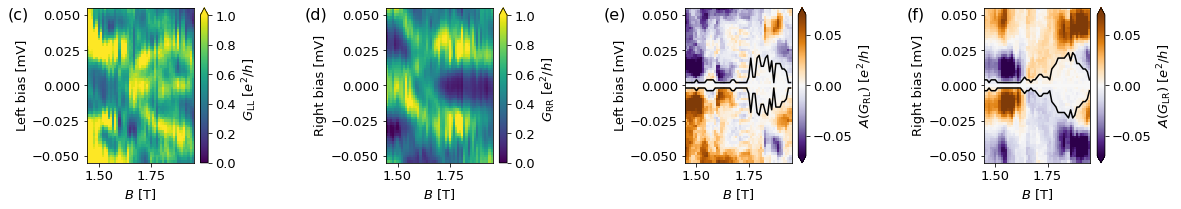

In [8]:
plot()

In [9]:
from ipywidgets import *

interact(plot, 
     c_test=Dropdown(options=[0,1,2,3], value=0, continuous_update=False),
     p_test=FloatSlider(
         min=xr_c_dataset_left['p'].min(), 
         max=xr_c_dataset_left['p'].max(), 
         step=np.diff(xr_c_dataset_left['p'])[0], 
         value=p_test, continuous_update=False),
);

interactive(children=(Dropdown(description='c_test', options=(0, 1, 2, 3), value=0), FloatSlider(value=-2.7221…

deviceC P724BB_00BA_1A_phase2_run2    c_test = 0    p_test = -2.7221    tf = 0.05


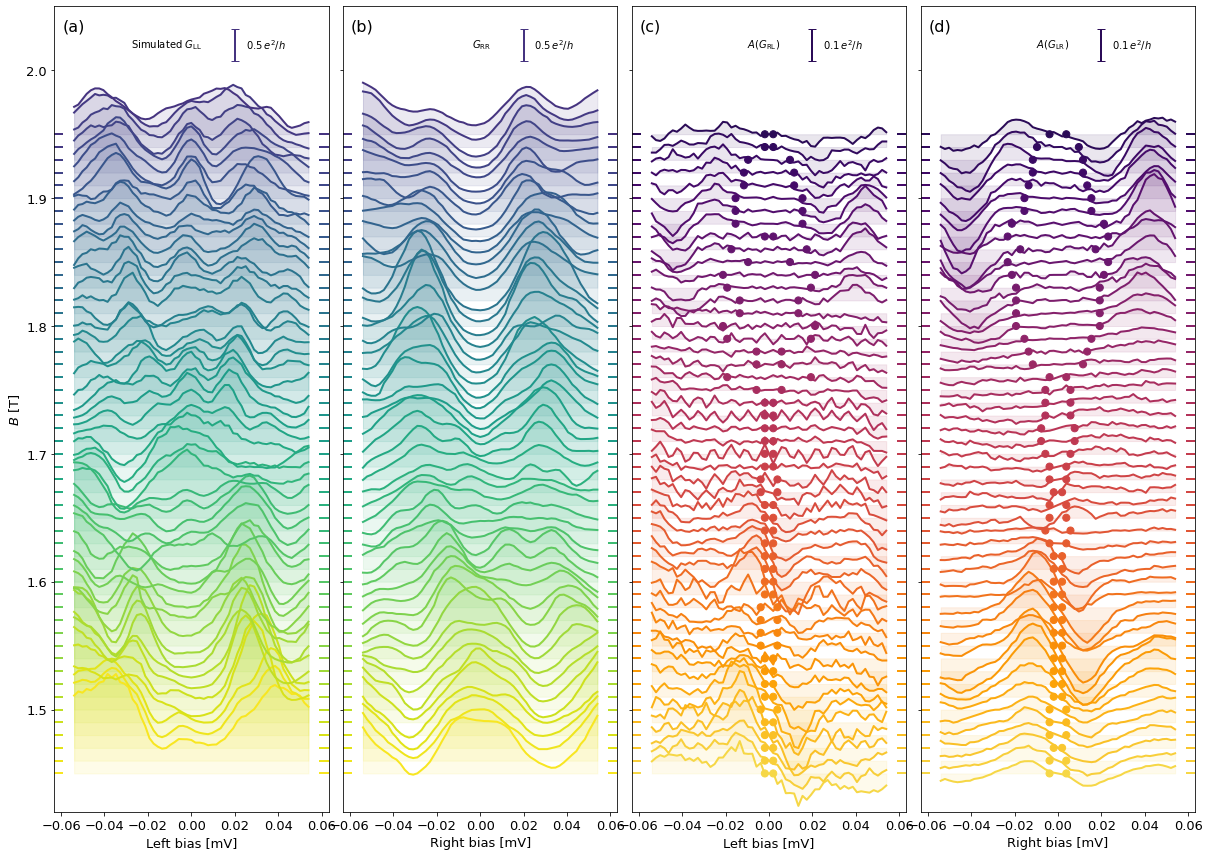

In [10]:
print(device_n, run_name, '   c_test =', c_test, '   p_test =', p_test, '   tf =', tf)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

g_rl = None

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(4.2*4, 12), sharey=True)

bmax = 0.055
g_ll = region.data['left'].sel({'p':p_test,'lc':c_test},method="nearest").where(np.abs(region.data['left']['lb'])<=0.1, np.nan).g_ll[0,0,:,:]
Vb = np.array(g_ll['lb'])
B = np.array(g_ll['f'])[:]
g_ll = np.array(g_ll)
colors = plt.cm.viridis(np.linspace(0.15, 0.99, B.shape[0]))[::-1]


for b_ in range(0, B.shape[0]):
    g = np.array(g_ll[b_,:])
    scale_g = 0.05
    ax1.fill_between(Vb, float(B[b_]), float(B[b_]) + scale_g*g, color=colors[b_], alpha=0.1)
    ax1.plot(Vb, float(B[b_]) + scale_g*g, c=colors[b_], lw=2) # , zorder=1000+b_
    ax1.plot([-0.2, -bmax*1.08], [float(B[b_])]*2, c=colors[b_], lw=2)
    ax1.plot([bmax*1.08, 0.2], [float(B[b_])]*2, c=colors[b_], lw=2)

# plt.text(-0.17, -0.3, r'G_\mathrm{RL}', va='top')

ax1.text(-0.125+0.13, 2.02, r'Simulated $G_\mathrm{LL}$', ha='right', va='center')
gbar = 0.5
ax1.errorbar(-0.11+0.13, 2.02, yerr=0.5*scale_g*gbar, c=colors[-1], ecolor=colors[-1], elinewidth=2, capsize=4)
ax1.text(-0.105+0.13, 2.02, r'$%g\,e^2/h$' % gbar, ha='left', va='center')

# test = tgp.gap_extraction.determine_gap_2D(region.data['left'].sel({'p':p_test,'lc':c_test},method="nearest").g_rl,bias_name="lb",
#                                              filtered_antisym_g=True,gauss_sigma=gs,median_size=ms,threshold_factor=tf,shift=False)
# gap = ((test[0]>0) * (test[0]))[0,0,:]

# ax1.scatter(gap[::2], B, c=colors, s=50)
# ax1.scatter(-gap[::2], B, c=colors, s=50)

# ax1.invert_yaxis()
ax1.set_xlabel('Left bias [mV]')
ax1.set_xlim(-bmax*1.15, bmax*1.15)
ax1.set_ylabel('$B$ [T]')
# ax1.set_yticks(np.arange(2.5, -0.1, -0.5))
# ax2.set_ylim(0.27, 2.4)



g_rl, g_ll = None, None

# ax = plt.subplot(122)

g_rr = region.data['right'].sel({'p':p_test,'rc':c_test},method="nearest").where(np.abs(region.data['right']['rb'])<=0.1, np.nan).g_rr[0,0,:,:]
g_rr = np.array(g_rr)

for b_ in range(0, B.shape[0]):
    g = np.array(g_rr[b_,:])
#     scale_g = 0.3
    ax2.fill_between(Vb, float(B[b_]), float(B[b_]) + scale_g*g, color=colors[b_], alpha=0.1)
    ax2.plot(Vb, float(B[b_]) + scale_g*g, c=colors[b_], lw=2) # , zorder=1000+b_
    ax2.plot([-0.2, -bmax*1.08], [float(B[b_])]*2, c=colors[b_], lw=2)
    ax2.plot([bmax*1.08, 0.2], [float(B[b_])]*2, c=colors[b_], lw=2)

# plt.text(-0.17, -0.3, r'G_\mathrm{RL}', va='top')

ax2.text(-0.125+0.13, 2.02, r'$G_\mathrm{RR}$', ha='right', va='center')
# gbar = 0.5
ax2.errorbar(-0.11+0.13, 2.02, yerr=0.5*scale_g*gbar, c=colors[-1], ecolor=colors[-1], elinewidth=2, capsize=4)
ax2.text(-0.105+0.13, 2.02, r'$%g\,e^2/h$' % gbar, ha='left', va='center')

# test = tgp.gap_extraction.determine_gap_2D(region.data['left'].sel({'p':p_test,'lc':c_test},method="nearest").g_lr,bias_name="lb",
#                                              filtered_antisym_g=True,gauss_sigma=gs,median_size=ms,threshold_factor=tf,shift=False)
# gap = ((test[0]>0) * (test[0]))[0,0,:]

# ax2.scatter(gap[::2], B, c=colors, s=50)
# ax2.scatter(-gap[::2], B, c=colors, s=50)

# ax2.invert_yaxis()
ax2.set_xlabel('Right bias [mV]')
ax2.set_xlim(-bmax*1.15, bmax*1.15)
# ax2.set_yticks(np.arange(2.5, -0.1, -0.5))
# ax2.set_ylim(0.27, 2.4)


colors = plt.cm.inferno(np.linspace(0.15, 0.9, B.shape[0]))[::-1]

g_rl = region.data['left'].sel({'p':p_test,'lc':c_test},method="nearest").where(np.abs(region.data['left']['lb'])<=0.1, np.nan).g_rl[0,0,:,:]
Vb = np.array(g_rl['lb'])
B = np.array(g_rl['f'])[:]
g_rl = np.array(g_rl)
g_rl = 0.5*(g_rl - g_rl[:,::-1])

for b_ in range(0, B.shape[0]):
    g = np.array(g_rl[b_,:])
    scale_g = 0.25
    ax3.fill_between(Vb, float(B[b_]), float(B[b_]) + scale_g*g, color=colors[b_], alpha=0.1)
    ax3.plot(Vb, float(B[b_]) + scale_g*g, c=colors[b_], lw=2) # , zorder=1000+b_
    ax3.plot([-0.2, -bmax*1.08], [float(B[b_])]*2, c=colors[b_], lw=2)
    ax3.plot([bmax*1.08, 0.2], [float(B[b_])]*2, c=colors[b_], lw=2)

# plt.text(-0.17, -0.3, r'G_\mathrm{RL}', va='top')

ax3.text(-0.125+0.13, 2.02, r'$A(G_\mathrm{RL})$', ha='right', va='center')
gbar = 0.1
ax3.errorbar(-0.11+0.13, 2.02, yerr=0.5*scale_g*gbar, c=colors[-1], ecolor=colors[-1], elinewidth=2, capsize=4)
ax3.text(-0.105+0.13, 2.02, r'$%g\,e^2/h$' % gbar, ha='left', va='center')

# np.ones(g_rl['lb'].size)*float(g_rl['f'][b_])    
test = tgp.gap_extraction.determine_gap_2D(region.data['left'].sel({'p':p_test,'lc':c_test},method="nearest").g_rl,bias_name="lb",
                                             filtered_antisym_g=True,gauss_sigma=gs,median_size=ms,threshold_factor=tf,shift=False)
gap = ((test[0]>0) * (test[0]))[0,0,:]

ax3.scatter(gap[:], B, c=colors, s=50)
ax3.scatter(-gap[:], B, c=colors, s=50)

# ax3.invert_yaxis()
ax3.set_xlabel('Left bias [mV]')
ax3.set_xlim(-bmax*1.15, bmax*1.15)
# ax3.set_ylabel('$B$ [T]')
# ax3.set_yticks(np.arange(2.5, -0.1, -0.5))
# ax3.set_ylim(0.27, 2.4)



g_rl = None

# ax = plt.subplot(122)

g_lr = region.data['right'].sel({'p':p_test,'rc':c_test},method="nearest").where(np.abs(region.data['right']['rb'])<=0.1, np.nan).g_lr[0,0,:,:]
g_lr = np.array(g_lr)
g_lr = 0.5*(g_lr - g_lr[:,::-1])

for b_ in range(0, B.shape[0]):
    g = np.array(g_lr[b_,:])
#     scale_g = 2.0
    ax4.fill_between(Vb, float(B[b_]), float(B[b_]) + scale_g*g, color=colors[b_], alpha=0.1)
    ax4.plot(Vb, float(B[b_]) + scale_g*g, c=colors[b_], lw=2) # , zorder=1000+b_
    ax4.plot([-0.2, -bmax*1.08], [float(B[b_])]*2, c=colors[b_], lw=2)
    ax4.plot([bmax*1.08, 0.2], [float(B[b_])]*2, c=colors[b_], lw=2)

# plt.text(-0.17, -0.3, r'G_\mathrm{RL}', va='top')

ax4.text(-0.125+0.13, 2.02, r'$A(G_\mathrm{LR})$', ha='right', va='center')
# gbar = 0.05
ax4.errorbar(-0.11+0.13, 2.02, yerr=0.5*scale_g*gbar, c=colors[-1], ecolor=colors[-1], elinewidth=2, capsize=4)
ax4.text(-0.105+0.13, 2.02, r'$%g\,e^2/h$' % gbar, ha='left', va='center')

# np.ones(g_rl['lb'].size)*float(g_rl['f'][b_])    
test = tgp.gap_extraction.determine_gap_2D(region.data['right'].sel({'p':p_test,'rc':c_test},method="nearest").g_lr,bias_name="rb",
                                             filtered_antisym_g=True,gauss_sigma=gs,median_size=ms,threshold_factor=tf,shift=False)
gap = ((test[0]>0) * (test[0]))[0,0,:]

ax4.scatter(gap[:], B, c=colors, s=50)
ax4.scatter(-gap[:], B, c=colors, s=50)

# ax4.invert_yaxis()
ax4.set_xlabel('Right bias [mV]')
ax4.set_xlim(-bmax*1.15, bmax*1.15)
# ax4.set_yticks(np.arange(2.5, -0.1, -0.5))
ax4.set_ylim(1.42, 2.05)


ax1.text(0.03, 1-0.015, '(a)', c='k', ha='left', va='top', size=16, transform=ax1.transAxes)
ax2.text(0.03, 1-0.015, '(b)', c='k', ha='left', va='top', size=16, transform=ax2.transAxes)
ax3.text(0.03, 1-0.015, '(c)', c='k', ha='left', va='top', size=16, transform=ax3.transAxes)
ax4.text(0.03, 1-0.015, '(d)', c='k', ha='left', va='top', size=16, transform=ax4.transAxes)


plt.tight_layout()
# plt.savefig('%s_%s_G_B_bias_c%d_p%g_waterfall.pdf' % (device_n, run_name, c_test, p_test), dpi=300, transparent=True, bbox_inches='tight', pad_inches=0.1)
plt.show()